# Modelo Individualizado de HRTF Baseado em Random Forest e Parâmetros Antropométricos

Implementação do artigo de Teng & Zhong (2023)

In [1]:
# !pip install numpy pandas scikit-learn matplotlib seaborn netCDF4 scipy

In [2]:
import numpy as np
import pandas as pd
import netCDF4
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

def get_frequency_bins(fs=44100, freq_min=1000, freq_max=12000, n_bins=64):
    n_samples = 256
    freqs = np.fft.rfftfreq(n_samples, 1/fs)
    
    freq_mask = (freqs >= freq_min) & (freqs <= freq_max) 
    selected_freqs = freqs[freq_mask]
    
    if len(selected_freqs) != n_bins:
        bin_edges = np.linspace(freq_min, freq_max, n_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        selected_indices = []
        for center in bin_centers:
            idx = np.argmin(np.abs(freqs - center))
            selected_indices.append(idx)
        
        selected_freqs = freqs[selected_indices]
    
    return selected_freqs, n_samples

/home/augusto/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Instalação das bibliotecas necessárias

Carregamento dos parâmetros antropométricos (Seção 2.1 do artigo)

In [3]:
data_dir = 'data/hutubs'
anthro_df = pd.read_csv(os.path.join(data_dir, 'AntrhopometricMeasures.csv'))

excluded_subjects = [18, 56, 79, 80, 92, 94]
anthro_df = anthro_df[~anthro_df['SubjectID'].isin(excluded_subjects)]

param_mapping = {
    'x1': 'a1', 'x2': 'a2', 'x3': 'a3', 'x4': 'a4', 'x5': 'a5',
    'x6': 'a6', 'x7': 'a7', 'x8': 'a8', 'x9': 'a9', 
    'x12': 'a10', 'x14': 'a11', 'x16': 'a12', 'x17': 'a13',
    'L_d1': 'a14'
}

anthropometric_data = pd.DataFrame()
anthropometric_data['SubjectID'] = anthro_df['SubjectID']

for old_col, new_col in param_mapping.items():
    anthropometric_data[new_col] = anthro_df[old_col]

anthropometric_data['a15'] = anthropometric_data['a6'] * anthropometric_data['a8'] / 2.0
anthropometric_data['a16'] = anthropometric_data['a7'] * anthropometric_data['a8'] / 2.0  
anthropometric_data['a17'] = anthropometric_data['a9'] * anthropometric_data['a11'] / 2.0
anthropometric_data['a18'] = anthropometric_data['a10'] * anthropometric_data['a11'] / 2.0
anthropometric_data['a19'] = anthropometric_data['a12'] * (anthropometric_data['a6'] + anthropometric_data['a8']) / 2.0

Extração de HRTFs dos arquivos SOFA (Seção 2.2 - processamento de sinais)

In [4]:
def extract_hrtf_from_sofa(sofa_path, fs=44100):
    with netCDF4.Dataset(sofa_path, 'r') as dataset:
        ir_data = dataset.variables['Data.IR'][:]
        positions = dataset.variables['SourcePosition'][:]
        
        n_samples = ir_data.shape[2]
        
        hrir_left = ir_data[:, 0, :]
        hrir_right = ir_data[:, 1, :]
        
        hrtf_left = np.fft.rfft(hrir_left, axis=1)
        hrtf_right = np.fft.rfft(hrir_right, axis=1)
        
        selected_freqs, _ = get_frequency_bins(fs, 1000, 12000, 64)
        
        freqs = np.fft.rfftfreq(n_samples, 1/fs)
        freq_indices = [np.argmin(np.abs(freqs - f)) for f in selected_freqs]
        
        log_mag_left = 20 * np.log10(np.abs(hrtf_left[:, freq_indices]) + 1e-10)
        log_mag_right = 20 * np.log10(np.abs(hrtf_right[:, freq_indices]) + 1e-10)
        
        return log_mag_left, log_mag_right, selected_freqs, positions

Carregamento de todos os dados HRTF com média das posições (descoberta experimental)

In [5]:
hrtf_data = {}
frequencies = None
start_time = time.time()

for _, row in anthropometric_data.iterrows():
    subject_id = int(row['SubjectID'])
    sofa_file = os.path.join(data_dir, f'pp{subject_id}_HRIRs_measured.sofa')
    
    if os.path.exists(sofa_file):
        log_mag_left, log_mag_right, freqs, positions = extract_hrtf_from_sofa(sofa_file)
        hrtf_data[subject_id] = {
            'left': np.mean(log_mag_left, axis=0),
            'right': np.mean(log_mag_right, axis=0),
            'positions': positions
        }
        if frequencies is None:
            frequencies = freqs

load_time = time.time() - start_time

Preparação dos dados no formato do artigo (Seção 3.1 - metodologia)

In [6]:
def prepare_data_for_rf(anthropometric_df, hrtf_data, frequencies):
    X_list = []
    y_left_list = []
    y_right_list = []
    subject_ids_list = []
    
    for _, row in anthropometric_df.iterrows():
        subject_id = int(row['SubjectID'])
        if subject_id in hrtf_data:
            anthro_params = row[[f'a{i}' for i in range(1, 20)]].values
            
            for freq_idx, freq in enumerate(frequencies):
                features = np.concatenate([anthro_params, [freq]])
                
                X_list.append(features)
                y_left_list.append(hrtf_data[subject_id]['left'][freq_idx])
                y_right_list.append(hrtf_data[subject_id]['right'][freq_idx])
                subject_ids_list.append(subject_id)
    
    return np.array(X_list), np.array(y_left_list), np.array(y_right_list), np.array(subject_ids_list)

X, y_left, y_right, subject_ids = prepare_data_for_rf(anthropometric_data, hrtf_data, frequencies)

Normalização e divisão dos dados (80 treino / 10 teste conforme artigo)

In [7]:
unique_subjects = np.unique(subject_ids)
np.random.seed(42)
test_subjects = np.random.choice(unique_subjects, 10, replace=False)
train_subjects = np.setdiff1d(unique_subjects, test_subjects)

train_mask = np.isin(subject_ids, train_subjects)
test_mask = np.isin(subject_ids, test_subjects)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train = X_scaled[train_mask]
X_test = X_scaled[test_mask]
y_left_train = y_left[train_mask]
y_left_test = y_left[test_mask]
y_right_train = y_right[train_mask]
y_right_test = y_right[test_mask]
test_subject_ids = subject_ids[test_mask]

Treinamento do Random Forest (Seção 3.2 - parâmetros do modelo)

In [8]:
rf_params = {
    'n_estimators': 500,
    'max_features': 18,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': True,
    'oob_score': True,
    'random_state': 42,
    'n_jobs': -1
}

start_time = time.time()
rf_left = RandomForestRegressor(**rf_params)
rf_left.fit(X_train, y_left_train)

rf_right = RandomForestRegressor(**rf_params)
rf_right.fit(X_train, y_right_train)
train_time = time.time() - start_time

Predições e cálculo de métricas (Seção 4 - resultados)

In [9]:
y_left_pred = rf_left.predict(X_test)
y_right_pred = rf_right.predict(X_test)

r2_left = r2_score(y_left_test, y_left_pred)
r2_right = r2_score(y_right_test, y_right_pred)
mse_left = mean_squared_error(y_left_test, y_left_pred)
mse_right = mean_squared_error(y_right_test, y_right_pred)
mae_left = mean_absolute_error(y_left_test, y_left_pred)
mae_right = mean_absolute_error(y_right_test, y_right_pred)
rmse_left = np.sqrt(mse_left)
rmse_right = np.sqrt(mse_right)

Cálculo da distorção espectral (SD) conforme Equação 3 do artigo

In [10]:
def calculate_spectral_distortion(y_true, y_pred, subject_ids, subjects):
    sd_by_subject = {}
    for subject in subjects:
        mask = subject_ids == subject
        sd = np.abs(y_true[mask] - y_pred[mask])
        sd_by_subject[subject] = np.mean(sd)
    return sd_by_subject

sd_left = calculate_spectral_distortion(y_left_test, y_left_pred, test_subject_ids, test_subjects)
sd_right = calculate_spectral_distortion(y_right_test, y_right_pred, test_subject_ids, test_subjects)

sd_combined = {}
for subject in test_subjects:
    sd_combined[subject] = (sd_left[subject] + sd_right[subject]) / 2

mean_sd = np.mean(list(sd_combined.values()))
std_sd = np.std(list(sd_combined.values()))

Análise da importância das features (Seção 4.3 do artigo)

In [11]:
feature_names = [f'a{i}' for i in range(1, 20)] + ['frequency']
importance_avg = (rf_left.feature_importances_ + rf_right.feature_importances_) / 2

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_avg
}).sort_values('importance', ascending=False)

Estatísticas descritivas dos resultados

In [12]:
print(f"R² Score - Left Ear: {r2_left:.3f}")
print(f"R² Score - Right Ear: {r2_right:.3f}")
print(f"Mean SD: {mean_sd:.2f} dB")

R² Score - Left Ear: 0.875
R² Score - Right Ear: 0.821
Mean SD: 1.61 dB


Figura 1: Gráfico de dispersão das predições

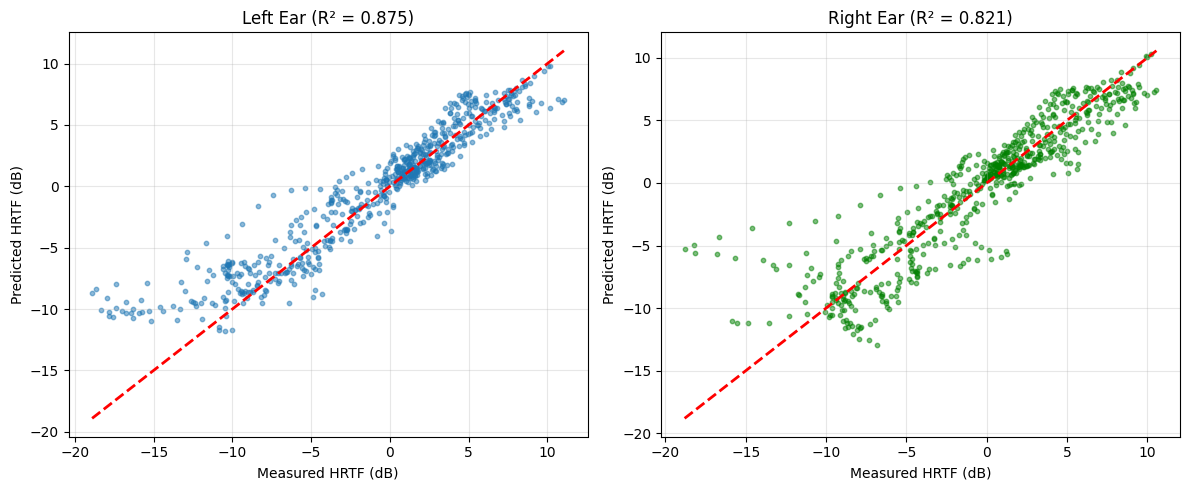

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_left_test, y_left_pred, alpha=0.5, s=10)
ax1.plot([y_left_test.min(), y_left_test.max()], 
         [y_left_test.min(), y_left_test.max()], 'r--', lw=2)
ax1.set_xlabel('Measured HRTF (dB)')
ax1.set_ylabel('Predicted HRTF (dB)')
ax1.set_title(f'Left Ear (R² = {r2_left:.3f})')
ax1.grid(True, alpha=0.3)

ax2.scatter(y_right_test, y_right_pred, alpha=0.5, s=10, color='green')
ax2.plot([y_right_test.min(), y_right_test.max()], 
         [y_right_test.min(), y_right_test.max()], 'r--', lw=2)
ax2.set_xlabel('Measured HRTF (dB)')
ax2.set_ylabel('Predicted HRTF (dB)')
ax2.set_title(f'Right Ear (R² = {r2_right:.3f})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Figura 2: Importância das features

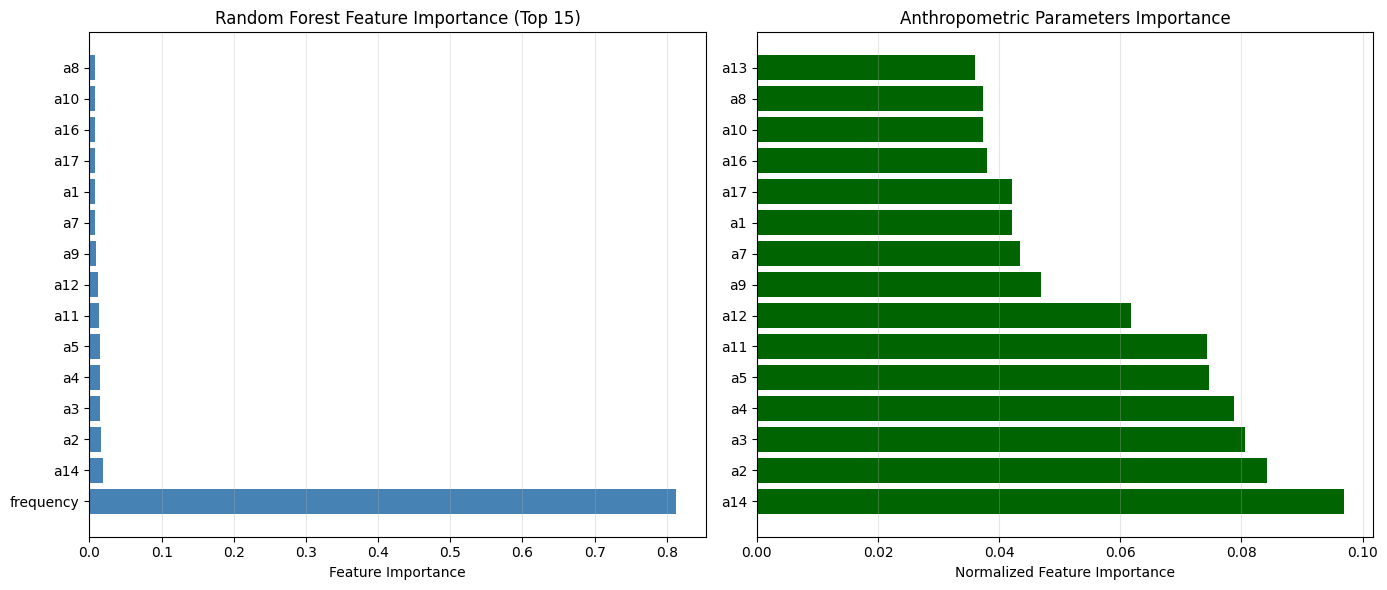

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

top_features = importance_df.head(15)
ax1.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Random Forest Feature Importance (Top 15)')
ax1.grid(True, alpha=0.3, axis='x')

importance_no_freq = importance_df[importance_df['feature'] != 'frequency'].copy()
importance_no_freq['importance'] = importance_no_freq['importance'] / importance_no_freq['importance'].sum()
top_features_no_freq = importance_no_freq.head(15)

ax2.barh(range(len(top_features_no_freq)), top_features_no_freq['importance'], color='darkgreen')
ax2.set_yticks(range(len(top_features_no_freq)))
ax2.set_yticklabels(top_features_no_freq['feature'])
ax2.set_xlabel('Normalized Feature Importance')
ax2.set_title('Anthropometric Parameters Importance')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Figura 3: Distorção espectral por frequência

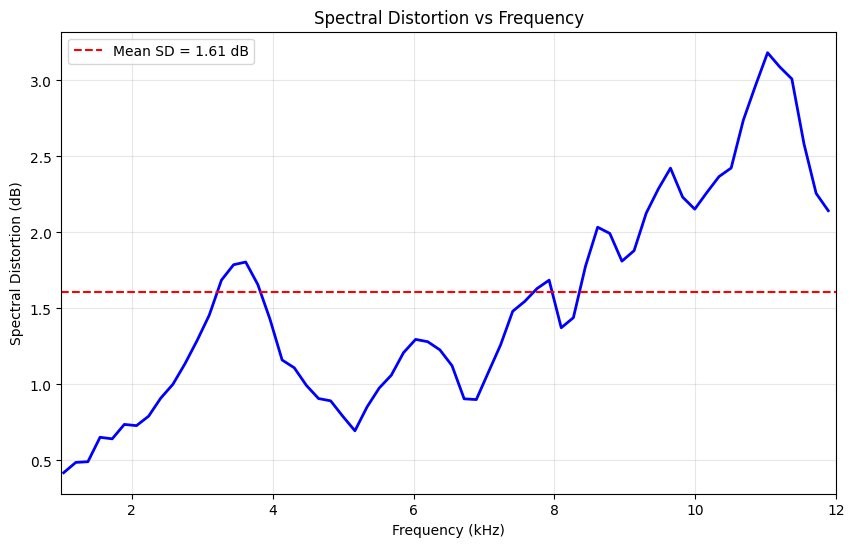

In [19]:
sd_by_freq = []
for freq_idx in range(len(frequencies)):
    freq_mask = X_test[:, -1] == scaler.transform([[0]*19 + [frequencies[freq_idx]]])[0, -1]
    if np.any(freq_mask):
        sd_freq = np.mean(np.abs(y_left_test[freq_mask] - y_left_pred[freq_mask]))
        sd_by_freq.append(sd_freq)
    else:
        sd_by_freq.append(0)

plt.figure(figsize=(10, 6))
plt.plot(frequencies/1000, sd_by_freq, 'b-', linewidth=2)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral Distortion (dB)')
plt.title('Spectral Distortion vs Frequency')
plt.grid(True, alpha=0.3)
plt.xlim(1, 12)
plt.axhline(y=mean_sd, color='r', linestyle='--', label=f'Mean SD = {mean_sd:.2f} dB')
plt.legend()
plt.show()

Figura 4: Distribuição dos erros de predição

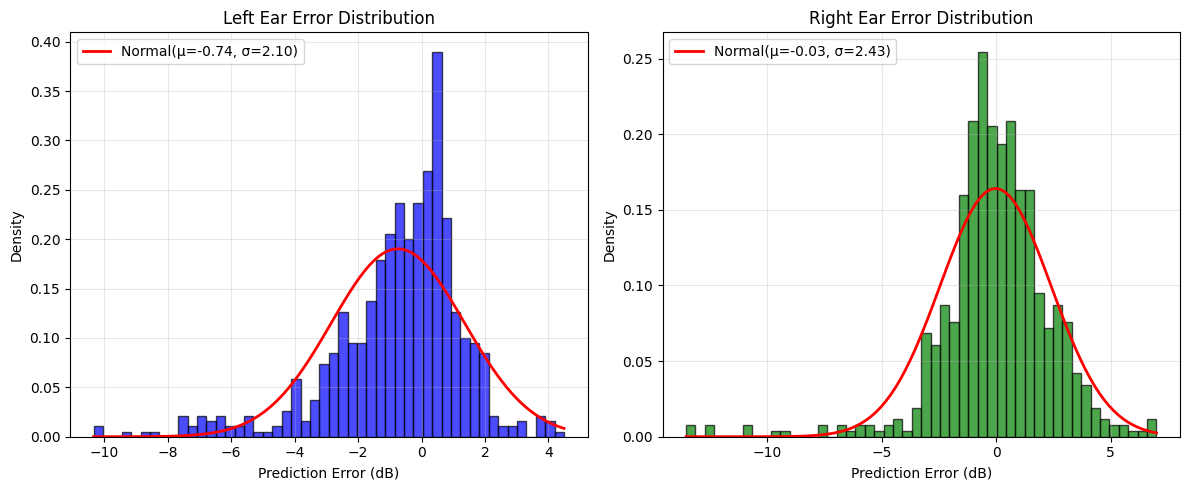

In [20]:
errors_left = y_left_test - y_left_pred
errors_right = y_right_test - y_right_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(errors_left, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
mu, sigma = stats.norm.fit(errors_left)
x = np.linspace(errors_left.min(), errors_left.max(), 100)
ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
ax1.set_xlabel('Prediction Error (dB)')
ax1.set_ylabel('Density')
ax1.set_title('Left Ear Error Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.hist(errors_right, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
mu, sigma = stats.norm.fit(errors_right)
x = np.linspace(errors_right.min(), errors_right.max(), 100)
ax2.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
ax2.set_xlabel('Prediction Error (dB)')
ax2.set_ylabel('Density')
ax2.set_title('Right Ear Error Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Estatísticas finais

In [21]:
print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of trees: {rf_params['n_estimators']}")
print(f"Max features: {rf_params['max_features']}")
print(f"Training time: {train_time:.1f} seconds")


Training samples: 5120
Test samples: 640
Number of trees: 500
Max features: 18
Training time: 5.7 seconds
